In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
from typing import List

from simulator_external.simulator.simulator import *
from simulator_external.simulator.load_data import load_md_from_file
from stoikov import StoikovStrategy
from simulator_external.simulator.get_info import get_pnl

In [4]:
PATH_TO_FILE = '../data/1/btcusdt:Binance:LinearPerpetual/'
NROWS = 3_000_000

In [5]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [6]:
def get_midprices(md: List[MdUpdate]) -> np.ndarray:
    midprices = []
    best_bid = -1
    best_ask = -1
    for update in md:
        if not midprices and update.orderbook is None:
            continue
        if update.orderbook is not None:
            best_bid = update.orderbook.bids[0][0]
            best_ask = update.orderbook.asks[0][0]
        elif update.trade is not None:
            trade = update.trade
            if trade.side == 'ASK':
                best_bid = trade.price
            elif trade.side == 'BID':
                best_ask = trade.price
        midprices.append((best_ask + best_bid) / 2)
    return np.array(midprices)

In [7]:
midprices = get_midprices(md)
increments = midprices[1:] - midprices[:-1]
sigma = np.std(increments)

In [8]:
print(f'σ = {sigma}')

σ = 0.6174799788254932


In [9]:
exec_latency = 10_000_000  # nanoseconds
md_latency = 10_000_000
sim = Sim(md, exec_latency, md_latency)

gamma = 0.1
k = 0.8  # calculated from BTCUSDT market data (see eda/eda-btc.ipynb)
adjust_delay = 1_000_000
precision = 2
strategy = StoikovStrategy(sim, gamma, k, sigma, adjust_delay, precision)

trades_list, md_list, updates_list, all_orders = strategy.run()

  0%|          | 0/5541356 [00:00<?, ?it/s]

In [10]:
pnl = get_pnl(updates_list)
pnl.receive_ts = pd.to_datetime(pnl.receive_ts)
pnl.exchange_ts = pd.to_datetime(pnl.exchange_ts)
pnl = pnl.iloc[::100, :].reset_index().drop(columns=['index'])

0it [00:00, ?it/s]

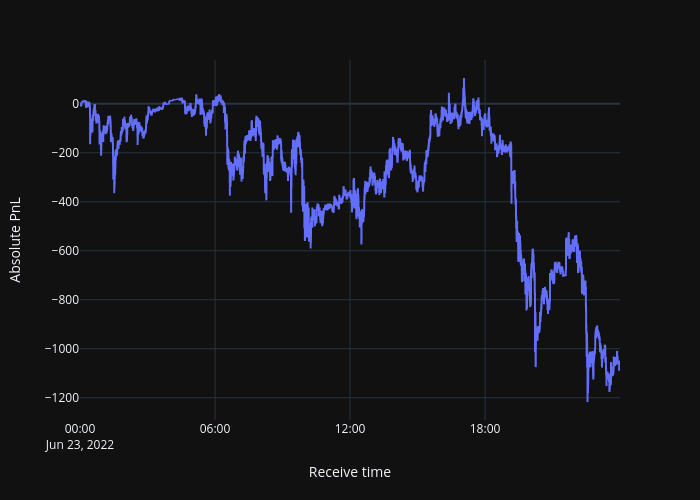

Opening in existing browser session.


[21046:21071:1107/171315.660514:ERROR:bus.cc(399)] Failed to connect to the bus: Could not parse server address: Unknown address type (examples of valid types are "tcp" and on UNIX "unix")
[21046:21071:1107/171315.660564:ERROR:bus.cc(399)] Failed to connect to the bus: Could not parse server address: Unknown address type (examples of valid types are "tcp" and on UNIX "unix")


In [12]:
fig = px.line(pnl, x='receive_ts', y='worth_quote')
fig.update_layout(xaxis_title='Receive time', yaxis_title='Account worth in quote asset',
                  title='PnL history')
fig.show(renderer='png')
fig.show(renderer='browser')